In [11]:
import torch
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from matplotlib.ticker import MaxNLocator
from regressor import *
from utils import *
from misc import * 
%load_ext autoreload
%autoreload 2
torch.manual_seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:35<00:00, 1407.96it/s]


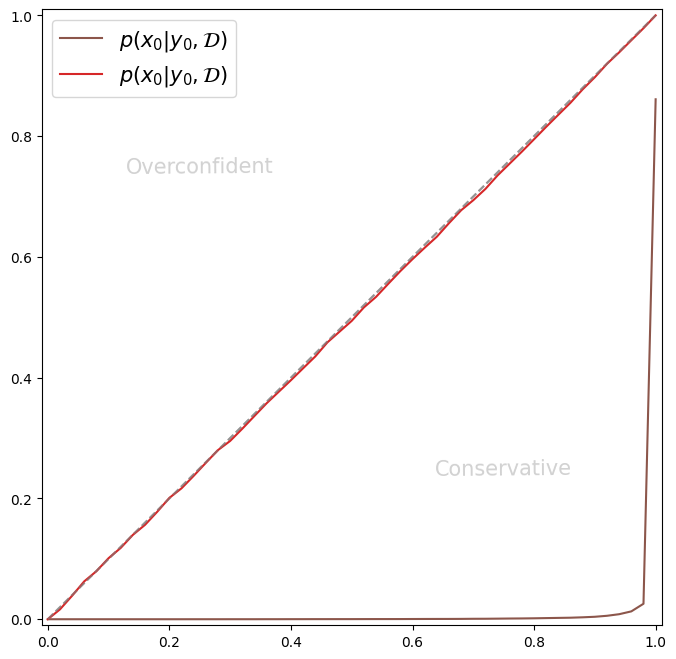

In [12]:
scale_sigma2 = torch.tensor(.5)
shape_sigma2 = torch.tensor(.5)
sigma20 = pyro.distributions.InverseGamma(shape_sigma2, scale_sigma2).sample()
sigma20 = torch.tensor(1)

mu_beta = torch.zeros(2)
Sigma_beta = torch.eye(2)
alpha =torch.distributions.MultivariateNormal(mu_beta, Sigma_beta).sample()
alpha = torch.tensor([1.,0.])

DGP = lambda x: alpha[0]*x + alpha[1] + torch.randn(x.shape[0])*torch.sqrt(sigma20)

mu_X0 =torch.tensor(6.)
sigma2_X0 =torch.tensor(1)
inference_prior =  torch.distributions.Normal(mu_X0, torch.sqrt(sigma2_X0))
x0 = inference_prior.sample()
n_y0= 1
y0 = DGP(x0.repeat(n_y0))

posterior_mean, posterior_sigma2 =generative_bayesian_linear_regression_known_variance(sigma20,mu_X0, sigma2_X0).compute_x0_given_y0_beta_moments(y0, torch.tensor(1.))
posterior = torch.distributions.Normal(posterior_mean, torch.sqrt(posterior_sigma2))

mu_Y0 = alpha[0]*mu_X0 + alpha[1]
sigma2_Y0 = sigma2_X0*alpha[0]**2 + sigma20
y_marginal = torch.distributions.Normal(mu_Y0, torch.sqrt(sigma2_Y0))

mu_DX = torch.tensor(0.)
sigma2_DX = torch.tensor(1.)
prior_dataset = torch.distributions.Normal(mu_DX,sigma2_DX)
n_D = 5000
DX =prior_dataset.sample([n_D])
DY = DGP(DX)

fake_posterior_mean, fake_posterior_sigma2 =generative_bayesian_linear_regression_known_variance(sigma20,mu_DX, sigma2_DX).compute_x0_given_y0_beta_moments(y0, torch.tensor(1.))
fake_posterior = torch.distributions.Normal(fake_posterior_mean, torch.sqrt(fake_posterior_sigma2))

y_min = torch.min(torch.cat([DY, y0]))-3.5
y_max = torch.max(torch.cat([DY, y0]))+3.5
x_min = torch.min(torch.cat([DX, x0.unsqueeze(-1)]))-3.5
x_max = torch.max(torch.cat([DX, x0.unsqueeze(-1)]))+3.5
tt = torch.linspace(x_min,x_max,300)

dlbr = discriminative_bayesian_affine_regression(mu_beta, Sigma_beta, shape_sigma2, scale_sigma2)
X0d,_,_ = dlbr.sample_x0_given_y0_D_Y_gibbs(y0, DX, DY, number_steps = 5000, verbose = True)
glbr = generative_bayesian_affine_regression(mu_X0, sigma2_X0,mu_beta, Sigma_beta, shape_sigma2, scale_sigma2)
X0g,_,_ = glbr.sample_x0_given_y0_D_Y_gibbs(y0, DX, DY, number_steps = 5000, verbose = True)
plt.figure(figsize = (8,8))
ax = plt.subplot()
ax.set_xlim(-0.01,1.01)
ax.set_ylim(-0.01,1.01)
plot_expected_coverage_1d_from_density(posterior.log_prob,[x_min,x_max], X0d.unsqueeze(-1), show=False, color ='C5', label = r'$p(x_0|y_0,\mathcal{D})$')
plot_expected_coverage_1d_from_density(posterior.log_prob,[x_min,x_max], X0g.unsqueeze(-1), show=False, color ='C3', label = r'$p(x_0|y_0,\mathcal{D})$')
plt.legend(ncol = 1, fontsize = 15, loc = 'upper left')
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [05:14<00:00, 15.87it/s]


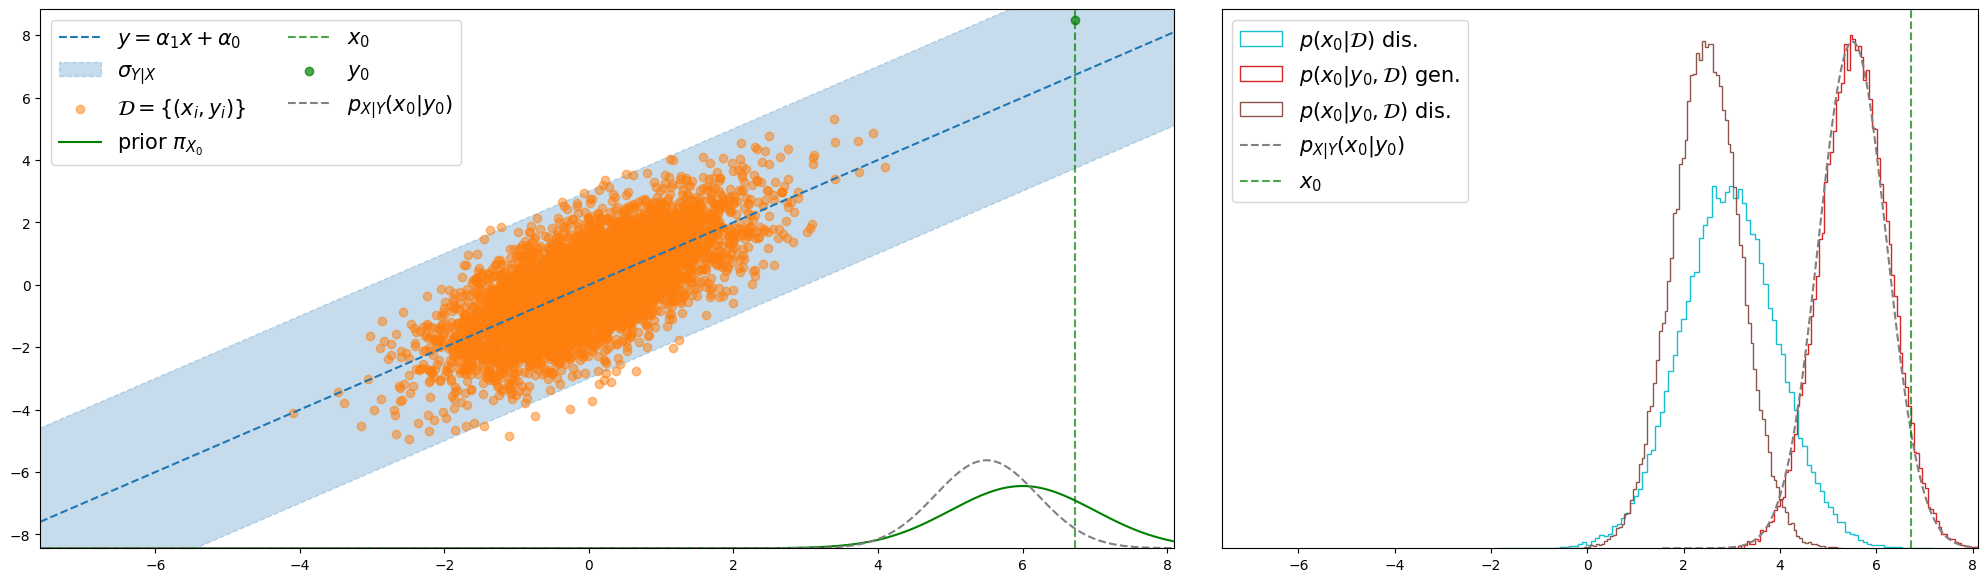

In [13]:
number_MC_samples = 500
list_x = []
list_beta = []
list_sigma = []
for i in tqdm(range(number_MC_samples)):
    x0 = inference_prior.sample()
    y0 = DGP(x0.unsqueeze(0))
    x,beta,sigma = dlbr.sample_x0_given_y0_D_Y_gibbs(y0,DX,DY)
    list_x.append(x[-10:])
    list_beta.append(beta)
    list_sigma.append(sigma)

fig = plt.figure(figsize = (25,7))
ax = fig.subplots(1, 2, gridspec_kw={'width_ratios': [3, 2]}, squeeze = True)
tt = torch.linspace(x_min,x_max,300)
ax[0].plot(tt.numpy(),(alpha[0]*tt+ alpha[1]).numpy(), linestyle = '--', label = r'$y = \alpha_1x+ \alpha_0$', color ='C0')
ax[0].fill_between(tt.numpy(),(alpha[0]*tt+ alpha[1]).numpy() - 3*torch.sqrt(sigma20).numpy(),(alpha[0]*tt+ alpha[1]).numpy() + 3*torch.sqrt(sigma20).numpy(),linestyle = '--',color = 'C0',alpha = 0.25, label = r'$\sigma_{Y|X}$')
ax[0].scatter(DX.numpy(), DY.numpy(), alpha =.5, label = r'$\mathcal{D}=\{(x_i,y_i)\}$', color = 'C1')
ax[0].plot(tt, y_min + 5*torch.exp(inference_prior.log_prob(tt.unsqueeze(-1))), color = 'green', label=r'prior $\pi_{X_0}$')
ax[0].axvline(x0.numpy(), color = 'green', alpha = .7, linestyle = '--', label='$x_0$')
ax[0].scatter(x0.repeat(n_y0), y0, color = 'green', alpha = .7, label = r'$y_0$')
ax[0].plot(tt,y_min+5*torch.exp(posterior.log_prob(tt)),linestyle ='--', label = r'$p_{X|Y}(x_0|y_0)$', color = 'grey')
ax[0].set_xlim(x_min,x_max)
ax[0].set_ylim(y_min,y_max)
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].yaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].legend(ncol = 2, fontsize = 15,loc = 'upper left')

tt = torch.linspace(torch.min(X0g)-1, torch.max(X0g)+1, 300)
ax[1].hist(torch.cat(list_x).numpy(), bins = 100, density = True, histtype = 'step', label = r'$p(x_0|\mathcal{D})$ dis.', color = 'C9')
ax[1].hist(X0d, bins = 100, density = True, histtype = 'step', label = r'$p(x_0|y_0,\mathcal{D})$ dis.', color = 'C5')
ax[1].hist(X0g, bins = 100, density = True, histtype = 'step', label = r'$p(x_0|y_0,\mathcal{D})$ gen.', color = 'C3')
ax[1].plot(tt, torch.exp(posterior.log_prob(tt)),linestyle ='--', label = r'$p_{X|Y}(x_0|y_0)$', color = 'grey')
ax[1].axvline(x0.numpy(), color = 'green', alpha = .7, linestyle = '--', label='$x_0$')
ax[1].tick_params(left=False,bottom=True,labelleft=False,labelbottom=True)
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].legend(ncol = 1, fontsize = 15,loc = 'upper left')
ax[1].set_xlim(x_min,x_max)
plt.subplots_adjust(wspace=0.05, hspace=0)
plt.show()

In [16]:
scale_sigma2 = torch.tensor(.5)
shape_sigma2 = torch.tensor(.5)
sigma20 = pyro.distributions.InverseGamma(shape_sigma2, scale_sigma2).sample()
sigma20 = torch.tensor(1)

mu_beta = torch.zeros(2)
Sigma_beta = torch.eye(2)
alpha =torch.distributions.MultivariateNormal(mu_beta, Sigma_beta).sample()
alpha = torch.tensor([1.,0.])

DGP = lambda x: alpha[0]*x + alpha[1] + torch.randn(x.shape[0])*torch.sqrt(sigma20)

mu_X0 =torch.tensor(3.)
sigma2_X0 =torch.tensor(1.)
inference_prior =  torch.distributions.Normal(mu_X0, torch.sqrt(sigma2_X0))
x0 = inference_prior.sample()
n_y0= 1
y0 = DGP(x0.repeat(n_y0))

posterior_mean, posterior_sigma2 =generative_bayesian_linear_regression_known_variance(sigma20,mu_X0, sigma2_X0).compute_x0_given_y0_beta_moments(y0, torch.tensor(1.))
posterior = torch.distributions.Normal(posterior_mean, torch.sqrt(posterior_sigma2))

mu_Y0 = alpha[0]*mu_X0 + alpha[1]
sigma2_Y0 = sigma2_X0*alpha[0]**2 + sigma20
y_marginal = torch.distributions.Normal(mu_Y0, torch.sqrt(sigma2_Y0))

mu_DX = torch.tensor(0.)
sigma2_DX = torch.tensor(2.)
prior_dataset = torch.distributions.Normal(mu_DX,torch.sqrt(sigma2_DX))
n_D = 2000
DX =prior_dataset.sample([n_D])
DY = DGP(DX)

fake_posterior_mean, fake_posterior_sigma2 =generative_bayesian_linear_regression_known_variance(sigma20,mu_DX, sigma2_DX).compute_x0_given_y0_beta_moments(y0, torch.tensor(1.))
fake_posterior = torch.distributions.Normal(fake_posterior_mean, torch.sqrt(fake_posterior_sigma2))

y_min = torch.min(torch.cat([DY, y0]))-3.5
y_max = torch.max(torch.cat([DY, y0]))+3.5
x_min = torch.min(torch.cat([DX, x0.unsqueeze(-1)]))-3.5
x_max = torch.max(torch.cat([DX, x0.unsqueeze(-1)]))+3.5
tt = torch.linspace(x_min,x_max,300)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:28<00:00, 1737.83it/s]


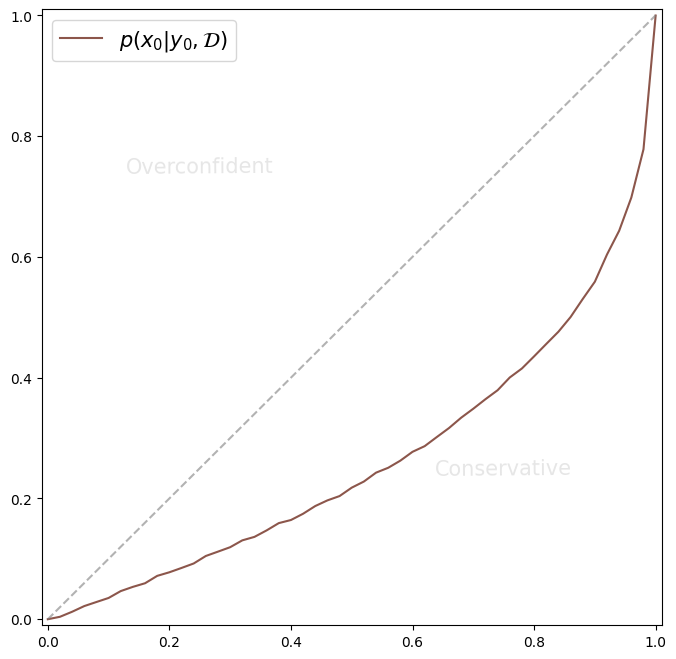

In [17]:
dlbr = discriminative_bayesian_affine_regression(mu_beta, Sigma_beta, shape_sigma2, scale_sigma2)
X0d,_,_ = dlbr.sample_x0_given_y0_D_Y_gibbs(y0, DX, DY, number_steps = 50000, verbose = True)
plt.figure(figsize = (8,8))
ax = plt.subplot()
ax.set_xlim(-0.01,1.01)
ax.set_ylim(-0.01,1.01)
plot_expected_coverage_1d_from_density(posterior.log_prob,[-20,40], X0d.unsqueeze(-1), show=False, color ='C5', label = r'$p(x_0|y_0,\mathcal{D})$')
plt.legend(ncol = 1, fontsize = 15,loc = 'upper left')
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 17.19it/s]


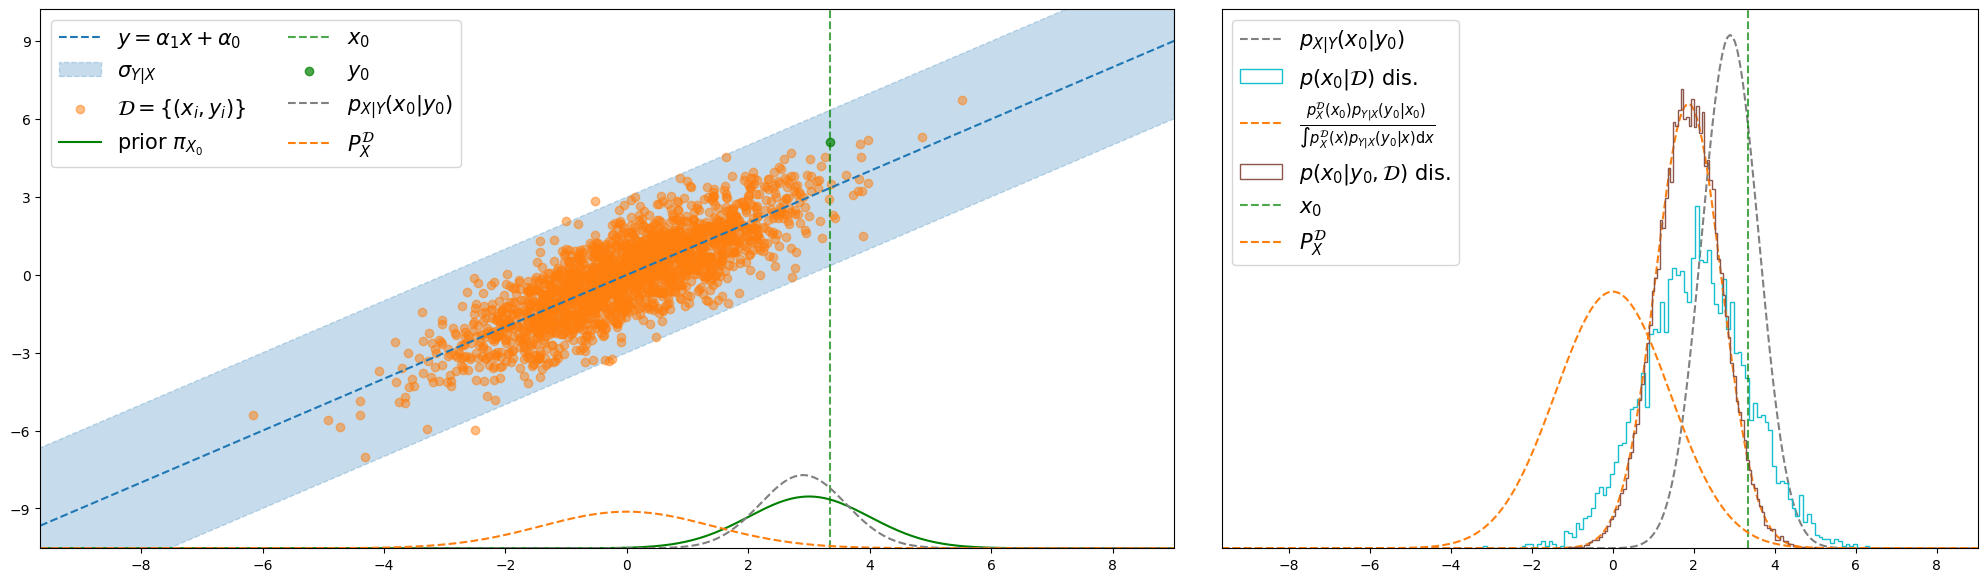

In [22]:
number_MC_samples = 500
list_x = []
list_beta = []
list_sigma = []
for i in tqdm(range(number_MC_samples)):
    x0 = inference_prior.sample()
    y0 = DGP(x0.unsqueeze(0))
    x,beta,sigma = dlbr.sample_x0_given_y0_D_Y_gibbs(y0,DX,DY)
    list_x.append(x[-10:])
    list_beta.append(beta)
    list_sigma.append(sigma)

fig = plt.figure(figsize = (25,7))
ax = fig.subplots(1, 2, gridspec_kw={'width_ratios': [3, 2]}, squeeze = True)
ax[0].plot(tt.numpy(),(alpha[0]*tt + alpha[1]).numpy(), linestyle = '--', label = r'$y = \alpha_1x+ \alpha_0$', color ='C0')
ax[0].fill_between(tt.numpy(),(alpha[0]*tt + alpha[1]).numpy() - 3*torch.sqrt(sigma20).numpy(),(alpha[0]*tt + alpha[1]).numpy() + 3*torch.sqrt(sigma20).numpy(),linestyle = '--',color = 'C0',alpha = 0.25, label = r'$\sigma_{Y|X}$')
ax[0].scatter(DX.numpy(), DY.numpy(), alpha =.5, label = r'$\mathcal{D}=\{(x_i,y_i)\}$', color = 'C1')
ax[0].plot(tt, y_min + 5*torch.exp(inference_prior.log_prob(tt.unsqueeze(-1))), color = 'green', label=r'prior $\pi_{X_0}$')
ax[0].axvline(x0.numpy(), color = 'green', alpha = .7, linestyle = '--', label='$x_0$')
ax[0].scatter(x0.repeat(n_y0), y0, color = 'green', alpha = .7, label = r'$y_0$')

ax[0].plot(tt,y_min+5*torch.exp(posterior.log_prob(tt)),linestyle ='--', label = r'$p_{X|Y}(x_0|y_0)$', color = 'grey')
ax[0].plot(tt,y_min+5*torch.exp(prior_dataset.log_prob(tt)),linestyle ='--', label = r'$P_{X}^{\mathcal{D}}$', color = 'C1')
ax[0].set_xlim(x_min,x_max)
ax[0].set_ylim(y_min,y_max)
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].yaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].legend(ncol = 2, fontsize = 15, loc = 'upper left')

ax[1].plot(tt, torch.exp(posterior.log_prob(tt)),linestyle = '--', label = r'$p_{X|Y}(x_0|y_0)$', color = 'grey')
ax[1].hist(torch.cat(list_x).numpy(), bins = 100, density = True, histtype = 'step', label = r'$p(x_0|\mathcal{D})$ dis.', color = 'C9')
ax[1].plot(tt, torch.exp(fake_posterior.log_prob(tt)),linestyle = '--', label = r'$\frac{p_{X}^{\mathcal{D}}(x_0)p_{Y|X}(y_0|x_0)}{\int p_{X}^{\mathcal{D}}(x)p_{Y|X}(y_0|x)\mathrm{d}x}$', color = 'C11')
ax[1].hist(X0d, bins = 100, density = True, histtype = 'step', label = r'$p(x_0|y_0,\mathcal{D})$ dis.', color = 'C5')
ax[1].axvline(x0.numpy(), color = 'green', alpha = .7, linestyle = '--', label='$x_0$')
ax[1].plot(tt,torch.exp(prior_dataset.log_prob(tt)),linestyle ='--', label = r'$P_{X}^{\mathcal{D}}$', color = 'C1')


ax[1].tick_params(left=False,bottom=True,labelleft=False,labelbottom=True)
ax[1].set_xlim(x_min,x_max)
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].legend(ncol = 1, fontsize = 15,loc = 'upper left')
plt.subplots_adjust(wspace=0.05, hspace=0)
plt.show()

In [7]:
scale_sigma2 = torch.tensor(.5)
shape_sigma2 = torch.tensor(.5)
sigma20 = pyro.distributions.InverseGamma(shape_sigma2, scale_sigma2).sample()
sigma20 = torch.tensor(1)

mu_beta = torch.zeros(2)
Sigma_beta = torch.eye(2)
alpha =torch.distributions.MultivariateNormal(mu_beta, Sigma_beta).sample()
alpha = torch.tensor([1.,0.])

DGP = lambda x: alpha[0]*x + alpha[1] + torch.randn(x.shape[0])*torch.sqrt(sigma20)

mu_X0 =torch.tensor(0.)
sigma2_X0 =torch.tensor(1.)
inference_prior =  torch.distributions.Normal(mu_X0, torch.sqrt(sigma2_X0))
x0 = inference_prior.sample()
n_y0= 1
y0 = DGP(x0.repeat(n_y0))

posterior_mean, posterior_sigma2 =generative_bayesian_linear_regression_known_variance(sigma20,mu_X0, sigma2_X0).compute_x0_given_y0_beta_moments(y0, torch.tensor(1.))
posterior = torch.distributions.Normal(posterior_mean, torch.sqrt(posterior_sigma2))

mu_Y0 = alpha[0]*mu_X0 + alpha[1]
sigma2_Y0 = sigma2_X0*alpha[0]**2 + sigma20
y_marginal = torch.distributions.Normal(mu_Y0, torch.sqrt(sigma2_Y0))

mu_DX = torch.tensor(0.)
sigma2_DX = torch.tensor(1.)
prior_dataset = torch.distributions.Normal(mu_DX,torch.sqrt(sigma2_DX))
n_D = 2000
DX =prior_dataset.sample([n_D])
DY = DGP(DX)

fake_posterior_mean, fake_posterior_sigma2 =generative_bayesian_linear_regression_known_variance(sigma20,mu_DX, sigma2_DX).compute_x0_given_y0_beta_moments(y0, torch.tensor(1.))
fake_posterior = torch.distributions.Normal(fake_posterior_mean, torch.sqrt(fake_posterior_sigma2))

y_min = torch.min(torch.cat([DY, y0]))-3.5
y_max = torch.max(torch.cat([DY, y0]))+3.5
x_min = torch.min(torch.cat([DX, x0.unsqueeze(-1)]))-3.5
x_max = torch.max(torch.cat([DX, x0.unsqueeze(-1)]))+3.5
tt = torch.linspace(x_min,x_max,300)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:28<00:00, 1781.55it/s]


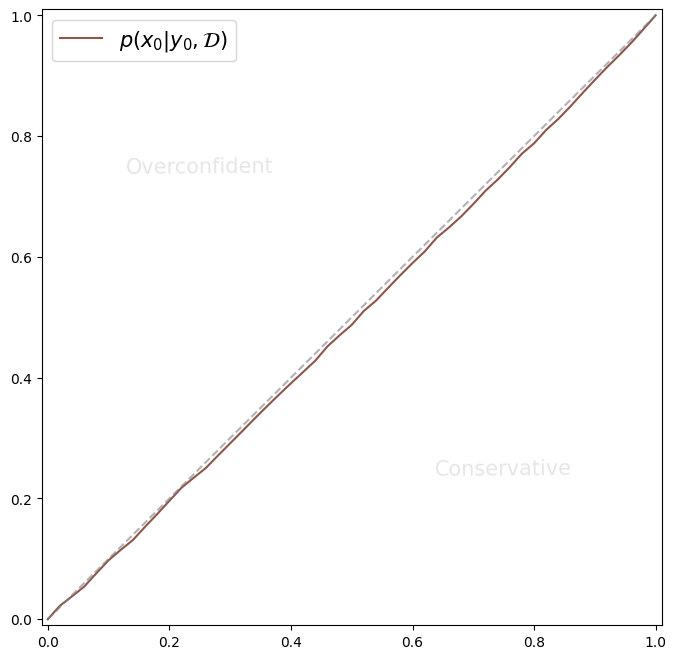

In [8]:
dlbr = discriminative_bayesian_affine_regression(mu_beta, Sigma_beta, shape_sigma2, scale_sigma2)
X0d,_,_ = dlbr.sample_x0_given_y0_D_Y_gibbs(y0, DX, DY, number_steps = 50000, verbose = True)
plt.figure(figsize = (8,8))
ax = plt.subplot()
ax.set_xlim(-0.01,1.01)
ax.set_ylim(-0.01,1.01)
plot_expected_coverage_1d_from_density(posterior.log_prob,[x_min,x_max], X0d.unsqueeze(-1), show=False, color ='C5', label = r'$p(x_0|y_0,\mathcal{D})$')
plt.legend(ncol = 3, fontsize = 15,loc = 'upper left')
plt.show()

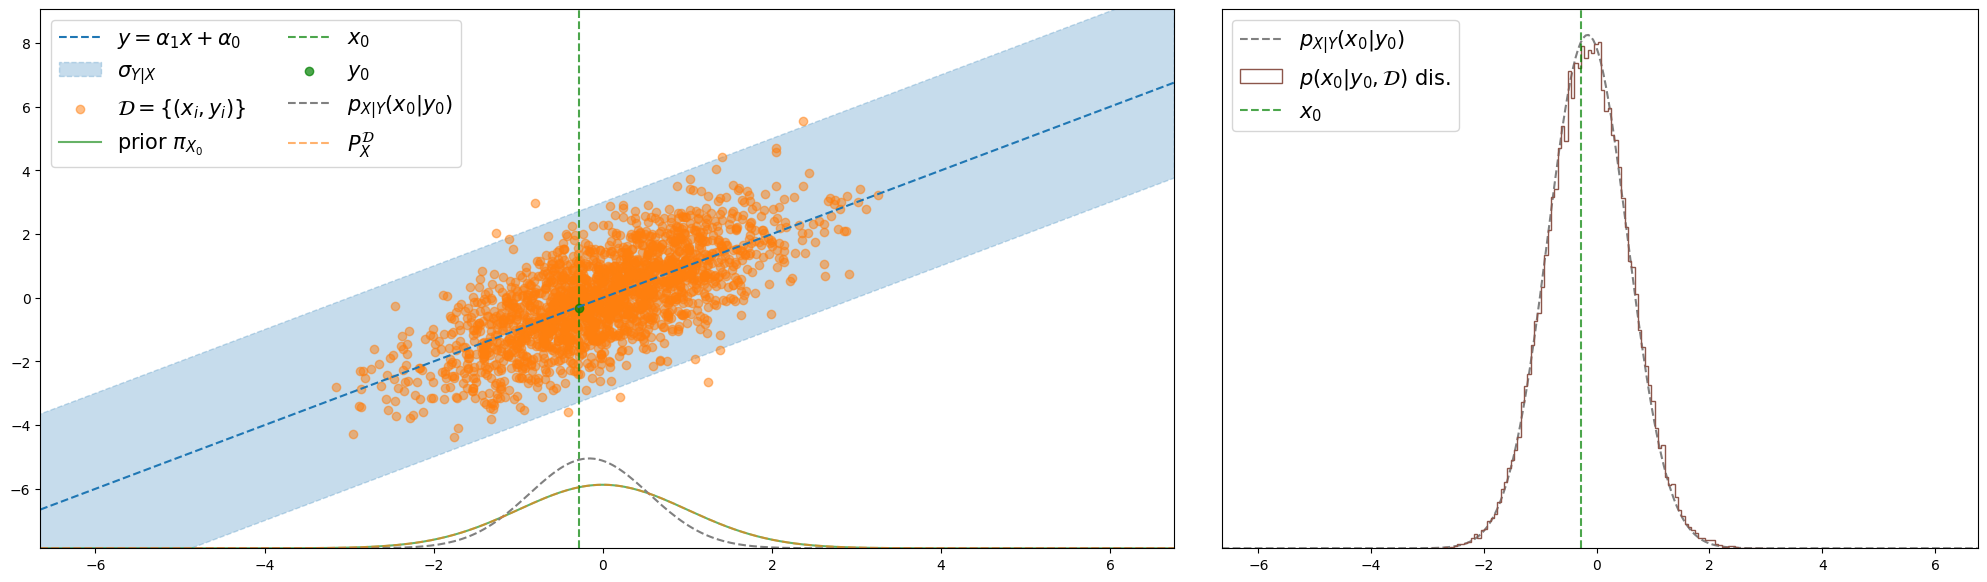

In [9]:
fig = plt.figure(figsize = (25,7))
ax = fig.subplots(1, 2, gridspec_kw={'width_ratios': [3, 2]}, squeeze = True)
ax[0].plot(tt.numpy(),(alpha[0]*tt + alpha[1]).numpy(), linestyle = '--', label = r'$y = \alpha_1x+ \alpha_0$', color ='C0')
ax[0].fill_between(tt.numpy(),(alpha[0]*tt + alpha[1]).numpy() - 3*torch.sqrt(sigma20).numpy(),(alpha[0]*tt + alpha[1]).numpy() + 3*torch.sqrt(sigma20).numpy(),linestyle = '--',color = 'C0',alpha = 0.25, label = r'$\sigma_{Y|X}$')
ax[0].scatter(DX.numpy(), DY.numpy(), alpha =.5, label = r'$\mathcal{D}=\{(x_i,y_i)\}$', color = 'C1')
ax[0].plot(tt, y_min + 5*torch.exp(inference_prior.log_prob(tt.unsqueeze(-1))), color = 'green', label=r'prior $\pi_{X_0}$', alpha = 0.6)
ax[0].axvline(x0.numpy(), color = 'green', alpha = .7, linestyle = '--', label='$x_0$')
ax[0].scatter(x0.repeat(n_y0), y0, color = 'green', alpha = .7, label = r'$y_0$')

ax[0].plot(tt,y_min+5*torch.exp(posterior.log_prob(tt)),linestyle ='--', label = r'$p_{X|Y}(x_0|y_0)$', color = 'grey')
ax[0].plot(tt,y_min+5*torch.exp(prior_dataset.log_prob(tt)),linestyle ='--', label = r'$P_{X}^{\mathcal{D}}$', color = 'C1', alpha = .6)
ax[0].set_xlim(x_min,x_max)
ax[0].set_ylim(y_min,y_max)
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].yaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].legend(ncol = 2, fontsize = 15, loc = 'upper left')

ax[1].plot(tt, torch.exp(posterior.log_prob(tt)),linestyle = '--', label = r'$p_{X|Y}(x_0|y_0)$', color = 'grey')
ax[1].hist(X0d, bins = 100, density = True, histtype = 'step', label = r'$p(x_0|y_0,\mathcal{D})$ dis.', color = 'C5')
ax[1].axvline(x0.numpy(), color = 'green', alpha = .7, linestyle = '--', label='$x_0$')

ax[1].tick_params(left=False,bottom=True,labelleft=False,labelbottom=True)
ax[1].legend(ncol = 1, fontsize = 15,loc = 'upper left')
ax[1].set_xlim(x_min,x_max)
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
plt.subplots_adjust(wspace=0.05, hspace=0)
plt.show()